In [1]:
import os
import sys
from google.colab import drive
print(os.path.abspath("."))
drive.mount('/content/drive/')
!pip install --no-binary :all: OpenEXR
path_to_module = '/content/drive/MyDrive/NNRT/'
sys.path.append(path_to_module)

/content
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
datadir='/content/drive/MyDrive/NNRT/'
sys.path.append(datadir)
from utils import *
import core
from abc import ABC, abstractmethod
from numpy import dot
import torch
from torch import tensor
import random
import numpy as np

def load_image_result(name):

  result=Image.open(datadir+'images/'+name)
  result.show()
  result=np.copy(result)
  print(result.shape)
  plt.axis('off')
  plt.imshow(result)
  result = result.astype('float32') / 255
  plt.show()
  result=torch.from_numpy(result[:,:,:])
  return result

import sys


def write_color(list,color):
  list.append(torch.sqrt(color[0]))
  list.append(torch.sqrt(color[1]))
  list.append(torch.sqrt(color[2]))
def write_color(tensorlist,color,index):
  tensorlist[index[0]][index[1]]=color
def write_pos(tensorlist,pos,index):
  tensorlist[index[0]][index[1]]=pos

def pixelsToimage(pixelsList:torch.Tensor,name):
  img=pixelsList.detach().numpy()*255
  #plt.savefig(datadir+"images/"+"test0001.png",dpi=100,bbox_inches='tight',pad_inches = -0.1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2.imwrite(datadir+"images/"+name+".jpg",img)

#

class HitRecord:
  def __init__(self,t=0.0,p=point3(0.0,0.0,0.0),normal=point3(0.0,0.0,0.0)):
    self.t=t
    self.p=p
    self.normal=normal
    self.material = None
    self.front_face=True
    self.u=0
    self.v=0

  def set_face_normal(self,ray,outward_normal):
    front_face=torch.dot(ray.direction,outward_normal)<0
    if front_face:
     normal = outward_normal
    else:
     normal = -outward_normal

class Hittable(ABC):
  @abstractmethod
  def hit(self,ray,t_min,t_max,hit_record):
    pass

class Hittable_List(Hittable):
  def __init__(self,hittable_objects):
    self.hittable_objects=hittable_objects
  def hit(self,ray,t_min,t_max,hit_record):
    tmp_hit_rec=HitRecord()
    hit_anything=False
    closest_so_far=t_max
    for item in self.hittable_objects:
      if item.hit(ray,t_min,closest_so_far,tmp_hit_rec):

        hit_anything= True
        closest_so_far=tmp_hit_rec.t
        hit_record.t=tmp_hit_rec.t
        hit_record.p=tmp_hit_rec.p
       # print(hit_anything)
        hit_record.normal=tmp_hit_rec.normal
        hit_record.material=tmp_hit_rec.material
    return hit_anything

class Sphere(Hittable):
  def __init__(self,center,radius,material):
    self.center=center
    self.radius=radius
    self.material=material
  def get_sphere_uv(self,p,u,v):
    theta = torch.acos(-p[1])
    phi=torch.atan2(-p[2],p[0])+torch.pi
    u=phi/(2*torch.pi)
    v=theta/torch.pi
    return u,v

  def hit(self,ray,t_min,t_max,hit_record):
    oc=ray.origin-self.center
    a=torch.dot(ray.direction,ray.direction)
    b=torch.dot(oc,ray.direction)
    c=torch.dot(oc,oc)-self.radius*self.radius
    discriminant=b*b-a*c
    if discriminant>0.0:
      temp=(-b-torch.sqrt(discriminant))/a
      if t_min<temp<t_max:
        hit_record.t=temp
        hit_record.p=ray.point_at_parameter(hit_record.t)
        hit_record.normal=(hit_record.p-self.center)/self.radius
        outward_normal=(hit_record.p-self.center)/self.radius

        hit_record.u,hit_record.v=self.get_sphere_uv(outward_normal,hit_record.u, hit_record.v);

        hit_record.set_face_normal(ray,outward_normal)
        hit_record.material=self.material
        return True
      temp=(-b+torch.sqrt(discriminant))/a
      if t_min<temp<t_max:
        hit_record.t=temp
        hit_record.p=ray.point_at_parameter(hit_record.t)
        hit_record.normal=(hit_record.p-self.center)/self.radius
        outward_normal=(hit_record.p-self.center)/self.radius
        hit_record.set_face_normal(ray,outward_normal)
        hit_record.material=self.material
        return True
    else:
      return False




<ipython-input-3-2024688e1670>:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  rgb32f = np.fromstring(src.channel(c, pixel_type), dtype=np.float32)


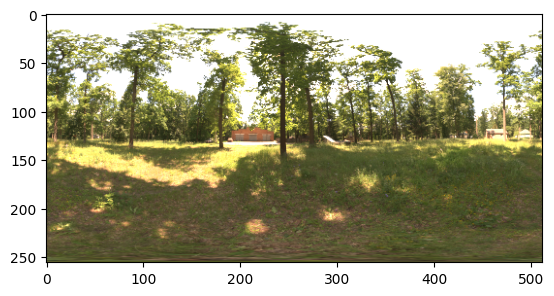

In [3]:
import matplotlib.pyplot as plt
import OpenEXR
import Imath
#设置光照贴图
def load_hdr_as_tensor(name):
    """Converts OpenEXR image to torch float tensor."""
    img_path=datadir+'hdr/'+name
    # Read OpenEXR file
    if not OpenEXR.isOpenExrFile(img_path):
        raise ValueError(f'Image {img_path} is not a valid OpenEXR file')
    src = OpenEXR.InputFile(img_path)
    pixel_type = Imath.PixelType(Imath.PixelType.FLOAT)
    dw = src.header()['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

    # Read into tensor
    tensor = torch.zeros((size[1],size[0],3))
    for i, c in enumerate('RGB'):
        rgb32f = np.fromstring(src.channel(c, pixel_type), dtype=np.float32)
        tensor[:,:,i] = torch.from_numpy(rgb32f.reshape(size[1], size[0]))

    plt.imshow(torch.sqrt(tensor).numpy())
    return torch.sqrt(tensor)

hdr=load_hdr_as_tensor("meadow_512.exr")
#Texture
from core import checker_texture,HDRtexture

hdrcolor=HDRtexture(hdr)

In [4]:
from core import Lambertian,Metal,Ray,HDRtexture
from utils import HarmonicEmbedding,color3,point3,normalize
import numpy as np
import math
from PIL import Image
import cv2
import torch
import os
path_to_module = '/content/drive/MyDrive/NNRT/'
sys.path.append(path_to_module)

from core import solid_color

def ray_color(r,world,depth):
  hit_record=HitRecord()
  if(depth<=0):
    return color3(0,0,0)
  color=color3(0,0,0)
  if(world.hit(r,0.001,sys.float_info.max,hit_record)):

    scattered=Ray(origin=color3(0.0, 0.0, 0.0), direction=color3(0.0,0.0,0.0))
    hit=hit_record.material.scatter(r,hit_record,scattered)
    attenuation=hit[1]
    return color + ray_color(scattered,world,depth-1).mul(attenuation)


  else:
    unit_direction = normalize(r.direction)
   # Graphics trick of scaling it to 0.0 < y < 1.0
    t = 0.5 * (unit_direction[1] + 1.0)
    return hdrcolor.color_value(-unit_direction)
   # return torch.tensor([1.0,1.0,1.0])*(1.0-t) + color3(0.5,0.7,1.0)*t






#====================================RunTime===============================

#Image
aspect_ratio=1
image_width=100
image_height=int(image_width*aspect_ratio)
samples_per_pixel=5
max_depth = 12


#world

checker=checker_texture(0.32,color3(0.2,0.3,0.1),color3(0.9,0.9,0.9))
objectList=[]
objectData=[]
objectList.append(Sphere(point3(0,0,0),0.5,Lambertian.from_color(color3(0.7,0.3,0.3))))
objectList.append(Sphere(point3(0,-100.5,-1),100,Lambertian(checker)))
#objectList.append(Sphere(point3(0,0,0),0.5,Lambertian(hdrcolor)))
objectList.append(Sphere(point3(-1.0,0.0,-1),0.5,Metal(color3(0.8,0.8,0.8),0.2)))
objectList.append(Sphere(point3(1.0,0.0,-1),0.5,Metal(color3(0.8,0.6,0.2),0.2)))
world=Hittable_List(objectList)

#camera
origin=torch.tensor([0.0,0.0,0.0])


delta_d = torch.rand(image_width,image_height,samples_per_pixel,2)
#delta_d=torch.reshape(delta_d,(image_width,image_height,samples_per_pixel,2))

#delta_d.requires_grad=True


import time
class Camera:
  def __init__(self,lookfrom,lookat,vup,vfov,aspect):
    #self.lens_radius=aperture/2.0
    self.theta=vfov*math.pi/180
    self.half_height = math.tan(self.theta/2)
    self.half_width=aspect*self.half_height
    self.w= normalize(lookfrom-lookat)

    print(vup.type)
    print(torch.cross(vup, self.w))
    self.u = normalize(torch.cross(vup, self.w))
    self.v = torch.cross(self.w, self.u)

    self.origin=lookfrom
    self.lower_left_corner=self.origin-self.u*self.half_width-self.v*self.half_height-self.w

    self.horizontal=self.u*self.half_width*2
    self.vertical=self.v*self.half_height*2




  def get_ray(self,u,v):
    return Ray(origin=self.origin,direction=self.lower_left_corner+self.horizontal*u+v*self.vertical-self.origin)
print(torch.cross(color3(0.0,0.0,-1.0),color3(0.0,1.0,0.0)))
Camera_position=point3(0.0,0.0,2.0)
#Camera
main_camera=Camera(Camera_position,color3(0.0,0.0,-2.0),color3(0.0,1.0,0.0),60,aspect_ratio)
def get_HDR_sample_vector(r):
  HDR_sample_vector=r-Camera_position;

import numpy

start=time.time()

def Renderimage(result):
  for j in range(image_height-1,-1,-1):
    if j%(image_height/10):
      print("progress:",j/image_height,"%")
    for i in range(0,image_width,1):
      pixelcolor = color3(0.0, 0.0, 0.0)
      pixelposition=color3(0.0, 0.0, 0.0)
      for s in range(0, samples_per_pixel, 1):
        u = (i+delta_d[i][j][s][0])/float(image_width-1)
        v = (j+delta_d[i][j][s][1])/float(image_height-1)



        r=main_camera.get_ray(u,v)

        pixelcolor=pixelcolor+ray_color(r,world,max_depth)
      pixelcolor/=samples_per_pixel

      index=image_height-j-1,i
      write_color(result,pixelcolor,index)

material=Lambertian.from_color(color3(0.3,0.3,0.3))
Solid_texture=solid_color(color3(0.3,0.3,0.3))
print(Solid_texture.color_value(0.2,0.3,color3(0.1,0.1,0.1)))

tensor([1., -0., 0.])
<built-in method type of Tensor object at 0x7ef36dc7e340>
tensor([1., 0., 0.])
tensor([0.3000, 0.3000, 0.3000])


progress: 0.99 %
progress: 0.98 %
progress: 0.97 %
progress: 0.96 %
progress: 0.95 %
progress: 0.94 %
progress: 0.93 %
progress: 0.92 %
progress: 0.91 %
progress: 0.89 %
progress: 0.88 %
progress: 0.87 %
progress: 0.86 %
progress: 0.85 %
progress: 0.84 %
progress: 0.83 %
progress: 0.82 %
progress: 0.81 %
progress: 0.79 %
progress: 0.78 %
progress: 0.77 %
progress: 0.76 %
progress: 0.75 %
progress: 0.74 %
progress: 0.73 %
progress: 0.72 %
progress: 0.71 %
progress: 0.69 %
progress: 0.68 %
progress: 0.67 %
progress: 0.66 %
progress: 0.65 %
progress: 0.64 %
progress: 0.63 %
progress: 0.62 %
progress: 0.61 %
progress: 0.59 %
progress: 0.58 %
progress: 0.57 %
progress: 0.56 %
progress: 0.55 %
progress: 0.54 %
progress: 0.53 %
progress: 0.52 %
progress: 0.51 %
progress: 0.49 %
progress: 0.48 %
progress: 0.47 %
progress: 0.46 %
progress: 0.45 %
progress: 0.44 %
progress: 0.43 %
progress: 0.42 %
progress: 0.41 %
progress: 0.39 %
progress: 0.38 %
progress: 0.37 %
progress: 0.36 %
progress: 0.35

time=== 37.093388080596924


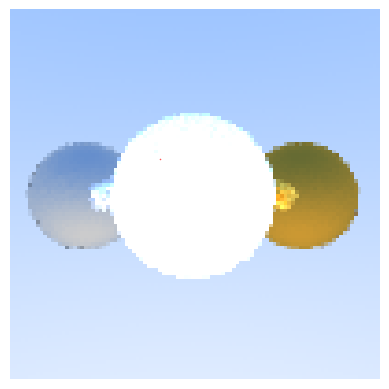

In [5]:
pixels=torch.zeros(image_width,image_width,3)

Renderimage(pixels)
end=time.time()
print("time===",end-start)
plt.scatter(40, 40, marker='v', s=0.01,color="red")
plt.axis("off")
plt.imshow(pixels.detach())

In [6]:
#Save
pixelsToimage(pixels,"color_sample")


(60, 60, 3)


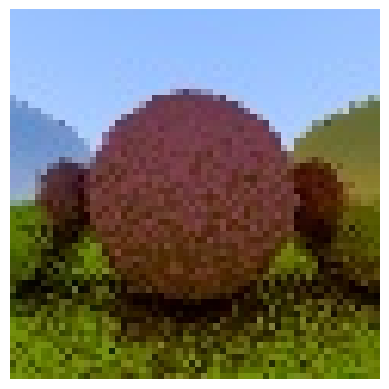

NameError: ignored

In [7]:

#x_seed=y_data2=load_image_result("normal001.jpg")
y_data2=y_data2=load_image_result("color001.jpg")
i=0
samples_per_pixel=1
#Image
aspect_ratio=1
image_width=100
image_height=int(image_width*aspect_ratio)
samples_per_pixel=5
max_depth = 12

pixels=torch.zeros(image_width,image_width,3)

albedo_input=torch.zeros(image_width,image_width,3)
positions_input=torch.zeros(image_width,image_width,3)
normals_input=torch.zeros(image_width,image_width,3)

Loss=[]
List=[]

def getInputData(r,world,depth):
  hit_record=HitRecord()
  color=color3(0,0,0)

  if(world.hit(r,0.001,sys.float_info.max,hit_record)):

    scattered=Ray(origin=color3(0.0, 0.0, 0.0), direction=color3(0.0,0.0,0.0))
    hit=hit_record.material.scatter(r,hit_record,scattered)
    input=torch.cat([hit_record.p,hit_record.normal],dim=0)
    return hit_record.material.albedo,hit_record.p,hit_record.normal

  else:
    unit_direction = normalize(r.direction)
       # Graphics trick of scaling it to 0.0 < y < 1.0
    t = 0.5 * (unit_direction[1] + 1.0)

    return color3(0.0,0.0,0.0),color3(0.0,0.0,0.0),color3(0.0,0.0,0.0)





# optimizer=torch.optim.Adam(model.parameters(),lr=0.00001,weight_decay=0.001)
def Render(result,camera):
  #result.requires_grad=False

  for j in range(image_height-1,-1,-1):
    for i in range(0,image_width,1):
      pixelcolor=color3(0.0,0.0,0.0)

      pixelposition=point3(0.0,0.0,0.0)
      pixelnormal=color3(0.0,0.0,0.0)
      index=image_height-j-1,i
      for s in range(0, samples_per_pixel, 1):
        u = (i+delta_d[i][j][s][0])/float(image_width-1)
        v = (j+delta_d[i][j][s][1])/float(image_height-1)

        r=camera.get_ray(u,v)
        #get input

        #c,p,n=getInputData(r,world,max_depth)
        #print(c.type)
        pixelcolor=pixelcolor+c
        pixelposition=pixelposition+p
        pixelnormal=pixelnormal+n

      pixelcolor/=samples_per_pixel
      pixelposition/=samples_per_pixel
      pixelnormal/=samples_per_pixel


      index=image_height-j-1,i
      write_color(albedo_input,pixelcolor,index)
      write_color(positions_input,pixelposition,index)
      write_color(normals_input,pixelnormal,index)
      #print(pixelposition)


        # List.append(color)

        # if(Hit==True):
        #   optimizer.zero_grad()
        #   loss=criterion(color,label[index[0]][index[1]])
        #   loss.backward()
        #   optimizer.step()
        #   Loss.append(loss.item())
  # meanLoss=torch.mean(torch.tensor(Loss))
  # print(meanLoss)

  return albedo_input,positions_input,normals_input

i=0
#torch.autograd.set_detect_anomaly(True)
while i <2 :
  i+=1
  _,_,_=Render(pixels,main_camera)
  plt.axis("off")
  #plt.imshow(albedo_input.detach())
  plt.imshow(positions_input.detach())
  #print(positions_input.detach())
 # plt.imshow(normals_input.detach())
  plt.show()


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        base_model = resnet34(pretrained=True)
        self.base_layers = list(base_model.children())[:-2]

        self.downs.append(DoubleConv(512, 1024))
        self.downs.append(DoubleConv(1024, 1024))
        self.ups.append(DoubleConv(1024 + 512, 512))
        self.ups.append(DoubleConv(512, 256))
        self.ups.append(DoubleConv(256, 128))
        self.ups.append(DoubleConv(128, 64))
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        features = []
        for layer in self.base_layers:
            x = layer(x)
            features.append(x)

        x = self.downs[0](x)
        x = self.pool(x)
        x = self.downs[1](x)

        for i in range(len(self.ups)):
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            x = torch.cat([x, features[-(i + 1)]], dim=1)
            x = self.ups[i](x)

        x = self.final_conv(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        return x

model = UNet(num_classes=len(classes))

In [ ]:

#x_seed=y_data2=load_image_result("normal001.jpg")
y_data2=y_data2=load_image_result("color001.jpg")
i=0
samples_per_pixel=1
pixels=torch.zeros(image_width,image_width,3)

albedo_result=torch.zeros(image_width,image_width,3)
positions=torch.zeros(image_width,image_width,3)
normals=torch.zeros(image_width,image_width,3)

Loss=[]
List=[]

def get_Color(r,world,depth):
  hit_record=HitRecord()
  color=color3(0,0,0)

  if(world.hit(r,0.001,sys.float_info.max,hit_record)):

    scattered=Ray(origin=color3(0.0, 0.0, 0.0), direction=color3(0.0,0.0,0.0))
    hit=hit_record.material.scatter(r,hit_record,scattered)
    input=torch.cat([hit_record.p,hit_record.normal],dim=0)
    print(input)
    return model(input).mul(hit[1]),True

  else:
    unit_direction = normalize(r.direction)
   # Graphics trick of scaling it to 0.0 < y < 1.0
    t = 0.5 * (unit_direction[1] + 1.0)

    return torch.tensor([1.0,1.0,1.0])*(1.0-t)+color3(0.5,0.7,1.0)*t,False
def get_pos(r,world,depth):
  hit_record=HitRecord()
  #if(depth<=0):
    #return color3(0,0,0)
  color=color3(0,0,0)

  if(world.hit(r,0.001,sys.float_info.max,hit_record)):
    scattered=Ray(origin=color3(0.0, 0.0, 0.0), direction=color3(0.0,0.0,0.0))
    hit=hit_record.material.scatter(r,hit_record,scattered)
    input=hit_record.p
    return input,hit[1],hit_record.normal,True

  else:
    unit_direction = normalize(r.direction)
   # Graphics trick of scaling it to 0.0 < y < 1.0
    t = 0.5 * (unit_direction[1] + 1.0)
    skycolor=torch.tensor([1.0,1.0,1.0])*(1.0-t)+color3(0.5,0.7,1.0)*t
    return skycolor,skycolor,-unit_direction,False

# def model_color(List):
#   #print(model(List).shape)
#   return model(List)
#harmonic 60,node 300,400
optimizer=torch.optim.Adam(model.parameters(),lr=0.00001,weight_decay=0.001)
def Render(result,label,camera):
  #result.requires_grad=False

  for j in range(image_height-1,-1,-1):
    for i in range(0,image_width,1):
      pixelcolor=color3(0.0,0.0,0.0)
      albedo=color3(0.0,0.0,0.0)
      normal=color3(0.0,0.0,0.0)
      #modelinput = color3(0.0, 0.0, 0.0)
      index=image_height-j-1,i
      for s in range(0, samples_per_pixel, 1):

        u = (i+delta_d[i][j][s][0])/float(image_width-1)
        v = (j+delta_d[i][j][s][1])/float(image_height-1)


        r=camera.get_ray(u,v)

       # color,al,normal_out,Hit=get_pos(r,world,max_depth)
        color,Hit=get_Color(r,world,max_depth)
        pixelcolor=pixelcolor+color
        #albedo=albedo+al
        #normal=normal+normal_out

        List.append(color)

        if(Hit==True):
          optimizer.zero_grad()
          loss=criterion(color,label[index[0]][index[1]])
          loss.backward()
          optimizer.step()
          Loss.append(loss.item())
      pixelcolor=pixelcolor/samples_per_pixel
      meanLoss=torch.mean(torch.tensor(Loss))
      #albedo=albedo/samples_per_pixel
      #normal=normal/samples_per_pixel
      #//一次forward
      #ndotL

      write_color(result,pixelcolor,index)
      #write_color(albedo_result,albedo,index)
     # write_color(normal_result,normal,index)
  meanLoss=torch.mean(torch.tensor(Loss))
  print(meanLoss)

  return result
  #result.requires_grad=True
  #model_color(result.detach())


#torch.autograd.set_detect_anomaly(True)
while i <50 :
  result=Render(pixels,y_data,main_camera)

  plt.axis("off")

  plt.imshow(result.detach())
  plt.show()

plt.show()

In [ ]:
image_width=256
image_height=256
samples_per_pixel=3
pixels=torch.zeros(image_width,image_width,3)
delta_d = torch.rand(image_width,image_height,samples_per_pixel,2)
def validRender(result,label,camera):
  #result.requires_grad=False

  for j in range(image_height-1,-1,-1):
    for i in range(0,image_width,1):
      pixelcolor=color3(0.0,0.0,0.0)
      albedo=color3(0.0,0.0,0.0)
      normal=color3(0.0,0.0,0.0)
      index=image_height-j-1,i
      for s in range(0, samples_per_pixel, 1):

        u = (i+delta_d[i][j][s][0])/float(image_width-1)
        v = (j+delta_d[i][j][s][1])/float(image_height-1)


        r=camera.get_ray(u,v)

       # color,al,normal_out,Hit=get_pos(r,world,max_depth)
        color,Hit=get_Color(r,world,max_depth)
        pixelcolor=pixelcolor+color
        #albedo=albedo+al
        #normal=normal+normal_out

        List.append(color)


      pixelcolor=pixelcolor/samples_per_pixel
      meanLoss=torch.mean(torch.tensor(Loss))
      #//一次forward
      #ndotL

      write_color(result,pixelcolor,index)

  meanLoss=torch.mean(torch.tensor(Loss))
  print(meanLoss)

  return result
  #result.requires_grad=True
  #model_color(result.detach())

#camera
origin=torch.tensor([0.0,1,0])

main_camera2=Camera(origin,point3(0.0,-1.0,-2.0),point3(0.0,1.0,0.0),90.0,aspect_ratio)

model.eval()
result=validRender(pixels,y_data,main_camera2)
#irradiance=model(result)

#irradiance=irradiance.reshape(image_height,image_height,3)
#color=irradiance*albedo_result#+torch.matmul(light,normal_result)

meanLoss=torch.mean(torch.tensor(Loss))

plt.axis("off")
plt.imshow(result.detach())
plt.show()
